In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2


2025-05-16 17:27:30.913396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747438050.925335    7422 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747438050.929242    7422 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747438050.939420    7422 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747438050.939430    7422 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747438050.939431    7422 computation_placer.cc:177] computation placer alr

In [2]:
# Function to count classes in the dataset
def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df


In [3]:
# Data paths
train_dir = './combined/train'
test_dir = './combined/test'


In [4]:
# Count classes in train and test datasets
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)
pd.concat([Train_Count, Test_Count], axis=1)


,Train,Test
happy,11986,2959
neutral,7488,1913
sad,6811,1725
angry,4693,1119
surprise,4460,1160
fear,4378,1098
disgust,1153,271
.ipynb_checkpoints,0,0


In [5]:
# Image parameters
img_shape = 224
batch_size = 64


In [6]:
# ImageDataGenerator for train and test data
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

train_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    classes=emotion_classes,
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)
test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    classes=emotion_classes,
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)


Found 40969 images belonging to 7 classes.
Found 10245 images belonging to 7 classes.


In [7]:
# Load pre-trained ResNet50V2 model
ResNet50V2_base = ResNet50V2(input_shape=(img_shape, img_shape, 3),
                             include_top=False,
                             weights='imagenet'
                             )

# Freeze all layers except last 50
ResNet50V2_base.trainable = True
for layer in ResNet50V2_base.layers[:-50]:
    layer.trainable = False

# Custom model using ResNet50V2
def Create_Custom_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2_base,
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

ResNet50V2_Model = Create_Custom_ResNet50V2_Model()
ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1747438055.510742    7422 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6


In [8]:
# Callbacks
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size


In [9]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data, validation_data=test_data, epochs=30, batch_size=batch_size,
                                           callbacks=callbacks, steps_per_epoch=steps_per_epoch,
                                           validation_steps=validation_steps)


/home/ojac/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1747438064.320088    7551 service.cc:152] XLA service 0x7fab40003b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747438064.320127    7551 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-16 17:27:44.563034: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747438065.917829    7551 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-05-16 18:26:15.809142: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng13{} for conv %cudnn-conv-bias-activation.104 = (f32[64,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,256,28,28]{3,2,1,0} %bitcast.21139, f32[512,256,1,1]{3,2,1,0} %bitcast.21135, f32[512]{0} %bitcast.21137, f32[64,512,28,28]{3,2,1,0} %bitcast.21227), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target

640/640 ━━━━━━━━━━━━━━━━━━━━ 272s 394ms/step - accuracy: 0.4423 - loss: 1.6540 - val_accuracy: 0.6176 - val_loss: 1.0516 - learning_rate: 0.0010
Epoch 2/30


2025-05-16 18:30:41.229058: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng18{k11=2} for conv %cudnn-conv-bw-filter.19 = (f32[512,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,512,7,7]{3,2,1,0} %bitcast.25833, f32[9,512,7,7]{3,2,1,0} %bitcast.25835), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/sequential_1/resnet50v2_1/conv5_block1_2_conv_1/convolution/Conv2DBackpropFilter" source_file="/home/ojac/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-16 18:30:41.234114: E external/local_xla/xla/service/slow_operation_alarm.cc:1

  1/640 ━━━━━━━━━━━━━━━━━━━━ 1:34:18 9s/step - accuracy: 0.4444 - loss: 0.9969

/home/ojac/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


640/640 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.4444 - loss: 0.9969 - val_accuracy: 0.6223 - val_loss: 1.0432 - learning_rate: 0.0010
Epoch 3/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 240s -5112433us/step - accuracy: 0.6102 - loss: 1.1035 - val_accuracy: 0.6465 - val_loss: 0.9964 - learning_rate: 0.0010
Epoch 4/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.4844 - loss: 1.4360 - val_accuracy: 0.6500 - val_loss: 0.9875 - learning_rate: 0.0010
Epoch 5/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 239s 373ms/step - accuracy: 0.6438 - loss: 1.0041 - val_accuracy: 0.6640 - val_loss: 0.9370 - learning_rate: 0.0010
Epoch 6/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7188 - loss: 0.8094 - val_accuracy: 0.6605 - val_loss: 0.9398 - learning_rate: 0.0010
Epoch 7/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 239s 374ms/step - accuracy: 0.6693 - loss: 0.9372 - val_accuracy: 0.6791 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 8/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7031 - l

In [10]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)
print("Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))


161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.6762 - loss: 0.9172
Test Loss: 0.76731
Test Accuracy: 73.30%


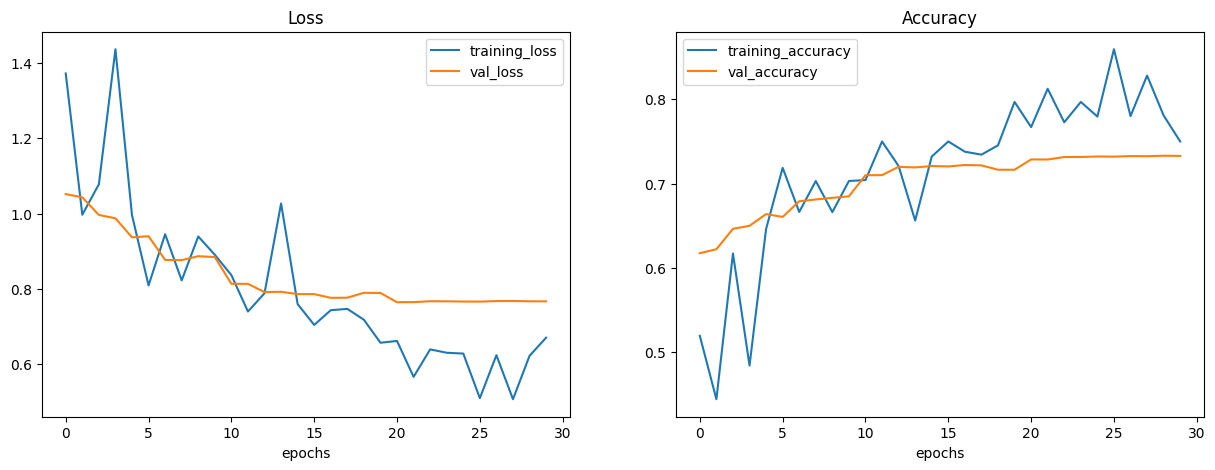

In [11]:
# Function to plot training curves
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_curves(ResNet50V2_history)

In [12]:
ResNet50V2_Model.save('resnet50v2_model.h5')

In [13]:
ResNet50V2_Model.save("resnet50v2_model.keras")  # Nuevo formato estándar y compatible

161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step


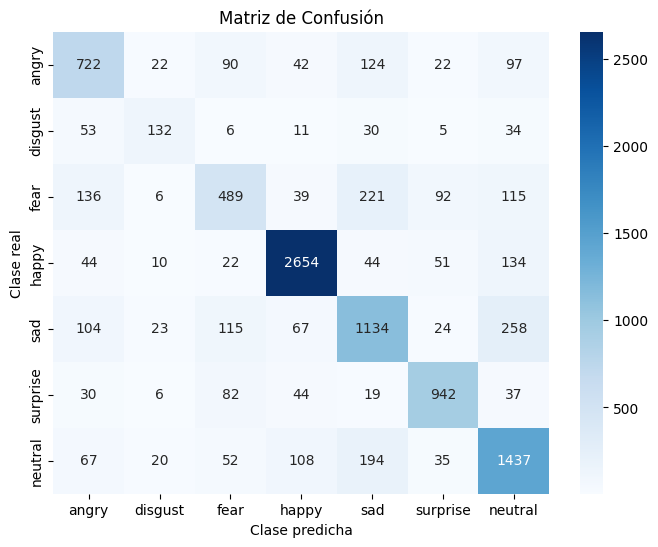

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Predecir clases en el set de test
y_true = test_data.classes
y_pred_probs = ResNet50V2_Model.predict(test_data, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 3. Graficar con heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=emotion_classes, 
            yticklabels=emotion_classes, cmap="Blues")
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de Confusión')
plt.show()


In [15]:
from sklearn.metrics import classification_report

# Generar reporte
report = classification_report(y_true, y_pred, target_names=emotion_classes, digits=4)
print(report)


              precision    recall  f1-score   support

       angry     0.6246    0.6452    0.6347      1119
     disgust     0.6027    0.4871    0.5388       271
        fear     0.5713    0.4454    0.5005      1098
       happy     0.8951    0.8969    0.8960      2959
         sad     0.6421    0.6574    0.6497      1725
    surprise     0.8044    0.8121    0.8082      1160
     neutral     0.6804    0.7512    0.7140      1913

    accuracy                         0.7330     10245
   macro avg     0.6887    0.6707    0.6774     10245
weighted avg     0.7302    0.7330    0.7302     10245



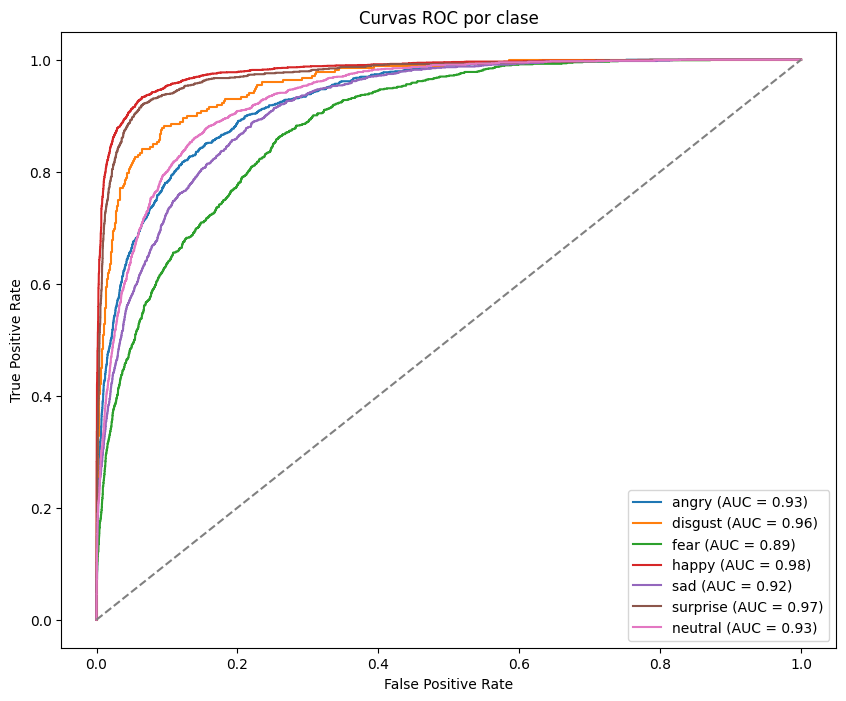

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 1. Binarizar etiquetas verdaderas
y_true_bin = label_binarize(y_true, classes=range(len(emotion_classes)))

# 2. Iterar por cada clase para calcular ROC
plt.figure(figsize=(10,8))
for i, emotion in enumerate(emotion_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {auc_score:.2f})")

# 3. Formato del gráfico
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('Curvas ROC por clase')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


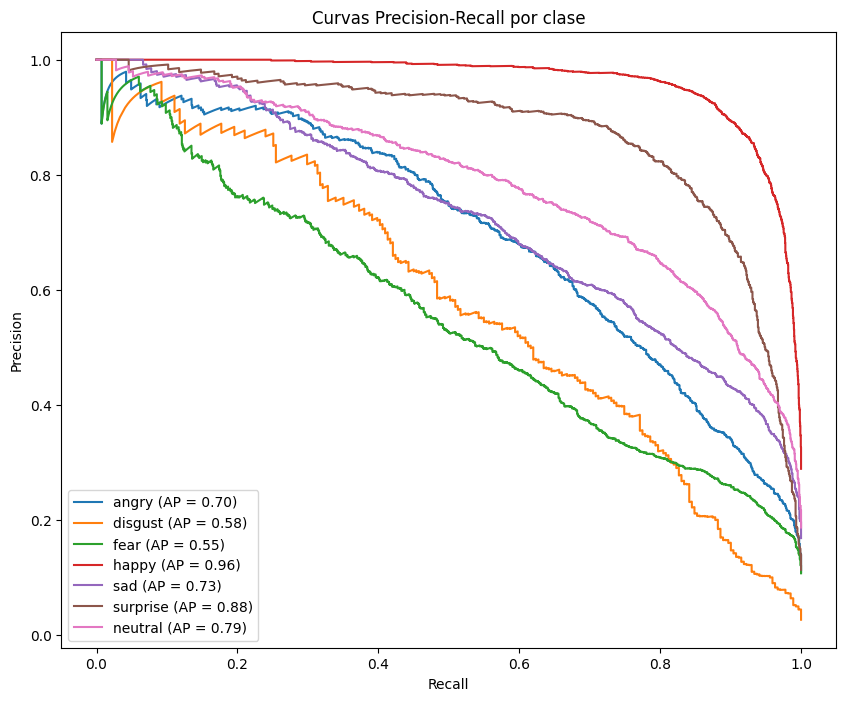

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))
for i, emotion in enumerate(emotion_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{emotion} (AP = {ap_score:.2f})")

plt.title('Curvas Precision-Recall por clase')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()


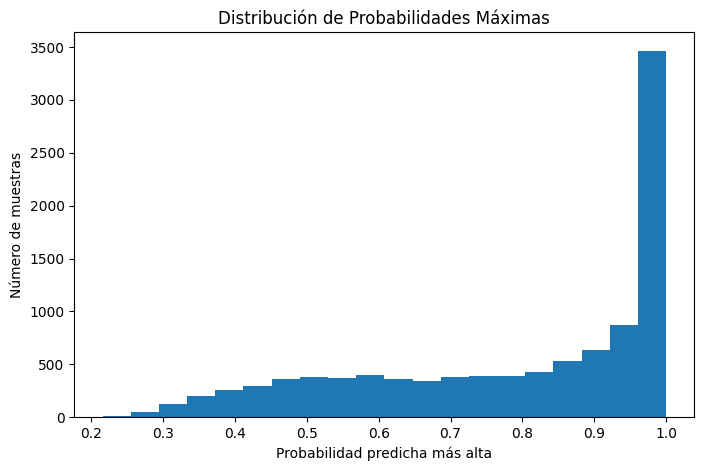

In [18]:
plt.figure(figsize=(8,5))
pred_max_probs = np.max(y_pred_probs, axis=1)
plt.hist(pred_max_probs, bins=20)
plt.title("Distribución de Probabilidades Máximas")
plt.xlabel("Probabilidad predicha más alta")
plt.ylabel("Número de muestras")
plt.show()
